<a href="https://colab.research.google.com/github/abhijeet3922/vision-RAG/blob/main/6_matching_interpretability_with_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook describes interpretzbility aspect of colpali model to understand how and why the model makes specific predictions.

We can visulaize image patches matching to each uery term by superimposing the late interaction heatmap on original image.

To demostrate interpretability, we perform following steps:

1. Create image and query embeddings.
2. Get similarity maps using API provided by colpali-engine
3. Plot maps

Acknowledgement

This notebook uses code or ideas from the following github repository:
https://github.com/illuin-tech/colpali

Installations & imports

In [1]:
!pip install pdf2image
!pip install colpali-engine[interpretability]
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from torch.utils.data import DataLoader
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,)

Load model

In [3]:
model_name = "vidore/colpali-v1.3"
model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",  # or "mps" if on Apple Silicon
).eval()
processor = ColPaliProcessor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at vidore/colpaligemma-3b-pt-448-base were not used when initializing ColPali: ['model.language_model.model.embed_tokens.weight', 'model.language_model.model.layers.0.input_layernorm.weight', 'model.language_model.model.layers.0.mlp.down_proj.weight', 'model.language_model.model.layers.0.mlp.gate_proj.weight', 'model.language_model.model.layers.0.mlp.up_proj.weight', 'model.language_model.model.layers.0.post_attention_layernorm.weight', 'model.language_model.model.layers.0.self_attn.k_proj.weight', 'model.language_model.model.layers.0.self_attn.o_proj.weight', 'model.language_model.model.layers.0.self_attn.q_proj.weight', 'model.language_model.model.layers.0.self_attn.v_proj.weight', 'model.language_model.model.layers.1.input_layernorm.weight', 'model.language_model.model.layers.1.mlp.down_proj.weight', 'model.language_model.model.layers.1.mlp.gate_proj.weight', 'model.language_model.model.layers.1.mlp.up_proj.weight', 'model.language_model.model.la

Process document, identify page to visulaize.

In [9]:
images = convert_from_path("/content/google-alphabet-2024.pdf")
print("Number of pages:", len(images))

Number of pages: 46


In [44]:
image = images[10]

In [45]:
query = ["Revenue Google Cloud 2023 and 2024 ?"]
query[0]

'Revenue Google Cloud 2023 and 2024 ?'

Process image and query using colpali

In [46]:
batch_images = processor.process_images([image]).to(model.device)
batch_queries = processor.process_queries(query[0]).to(model.device)

with torch.no_grad():
  image_embeddings = model.forward(**batch_images)
  query_embeddings = model.forward(**batch_queries)

In [47]:
# Get the number of image patches
n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size)
# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

In [48]:
query_embeddings.shape, image_embeddings.shape

(torch.Size([36, 15, 128]), torch.Size([1, 1031, 128]))

In [49]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

In [50]:
# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)
# Tokenize the query
query_tokens = processor.tokenizer.tokenize(query[0])


In [51]:
similarity_maps.shape, len(query_tokens)

(torch.Size([15, 32, 32]), 15)

Plot similarity maps

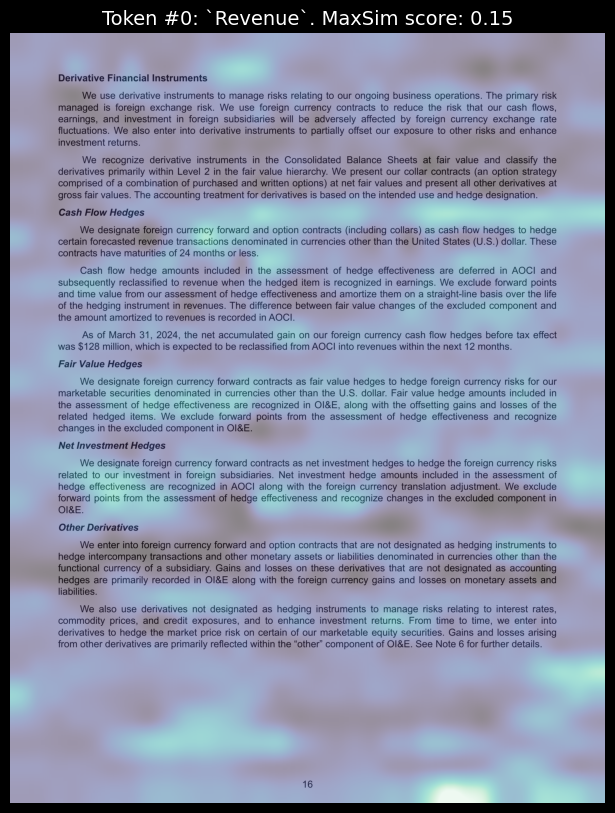

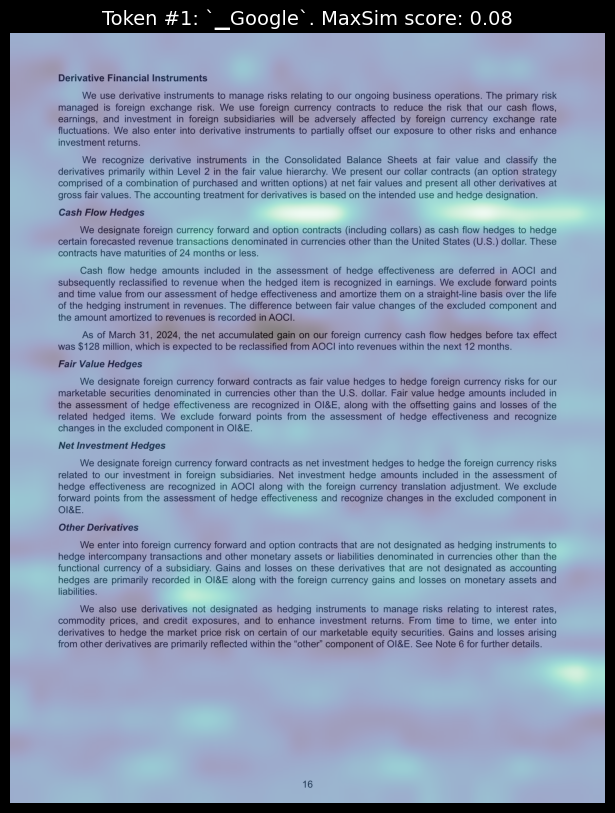

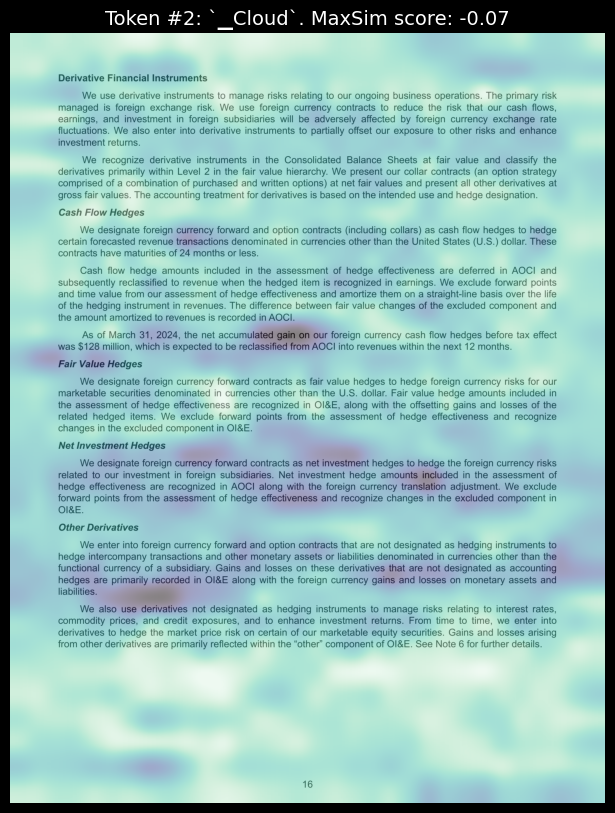

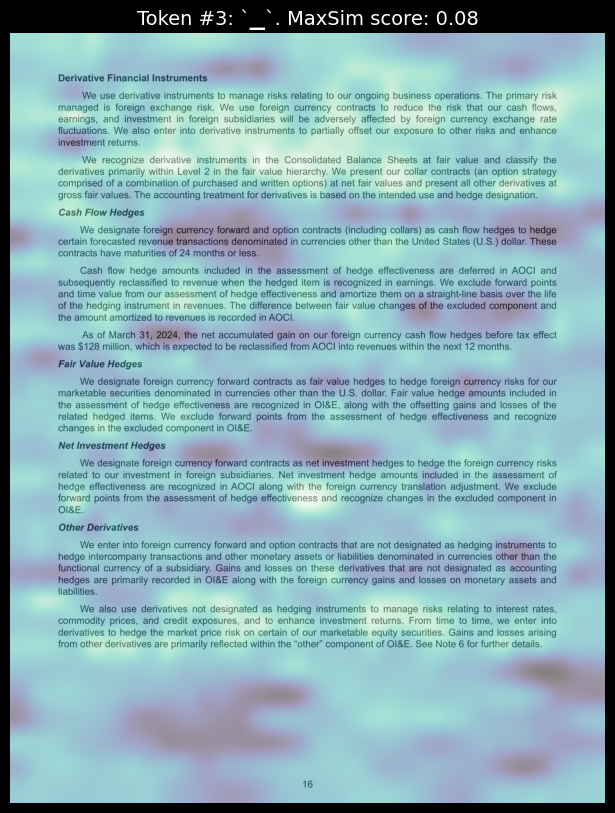

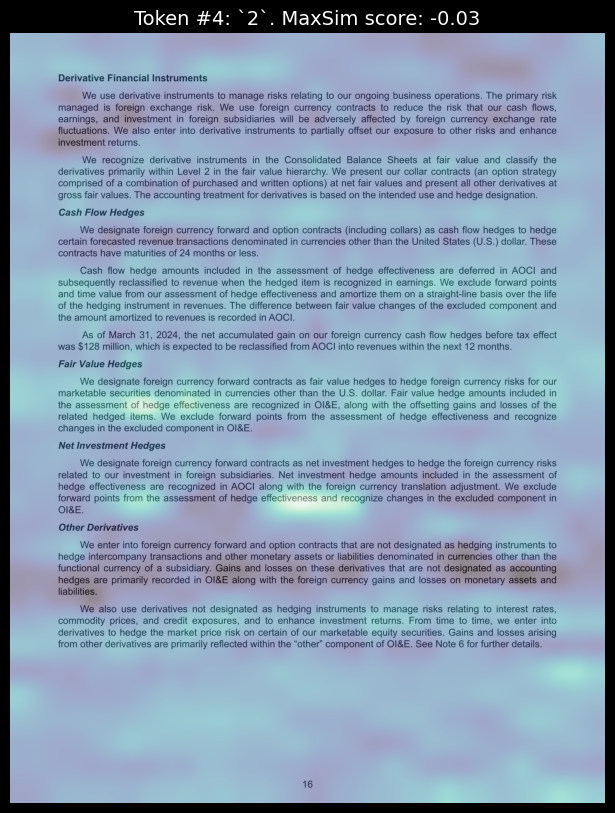

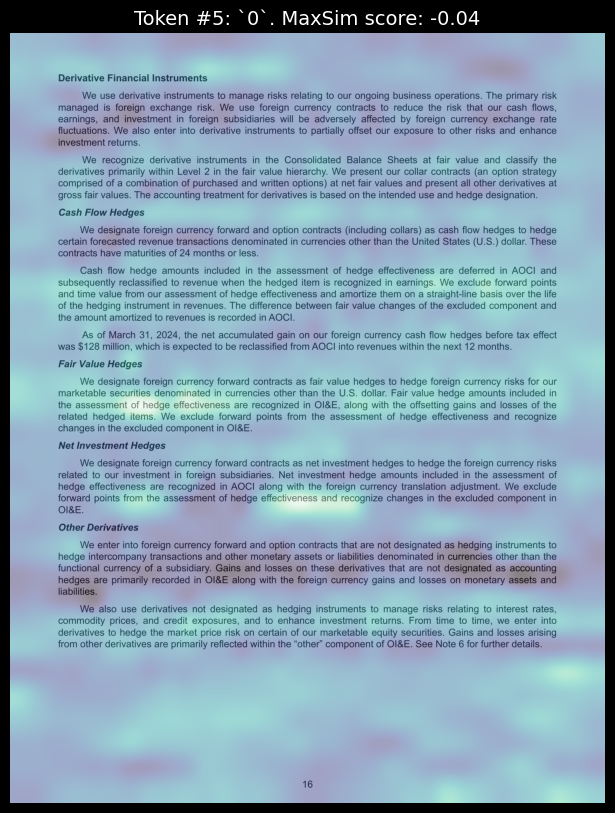

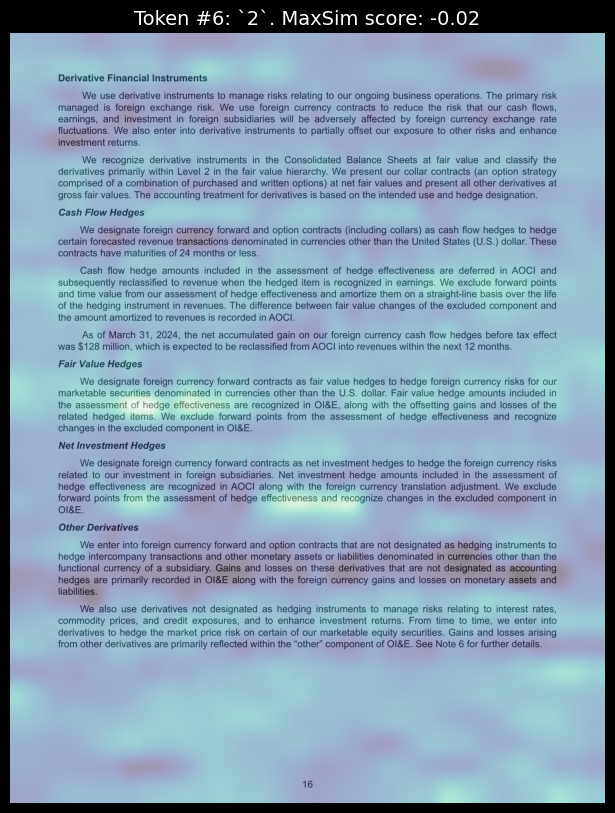

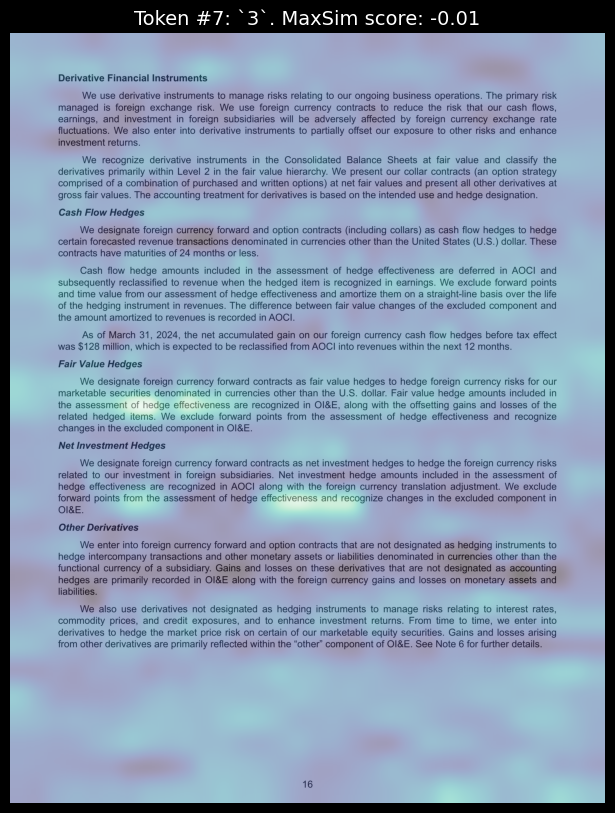

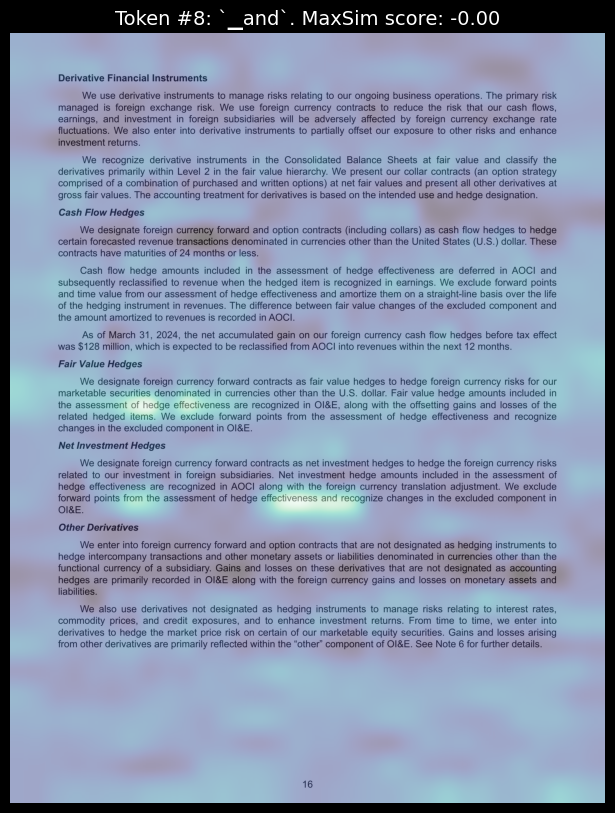

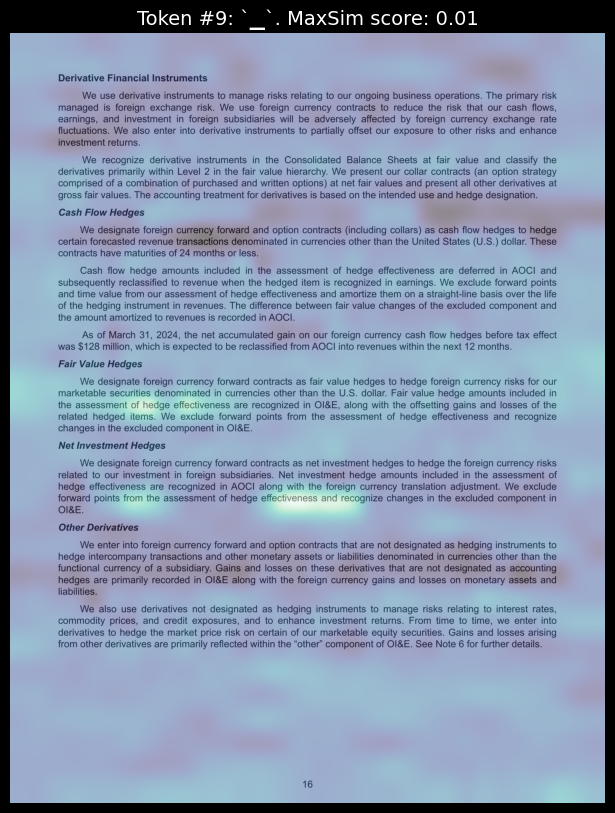

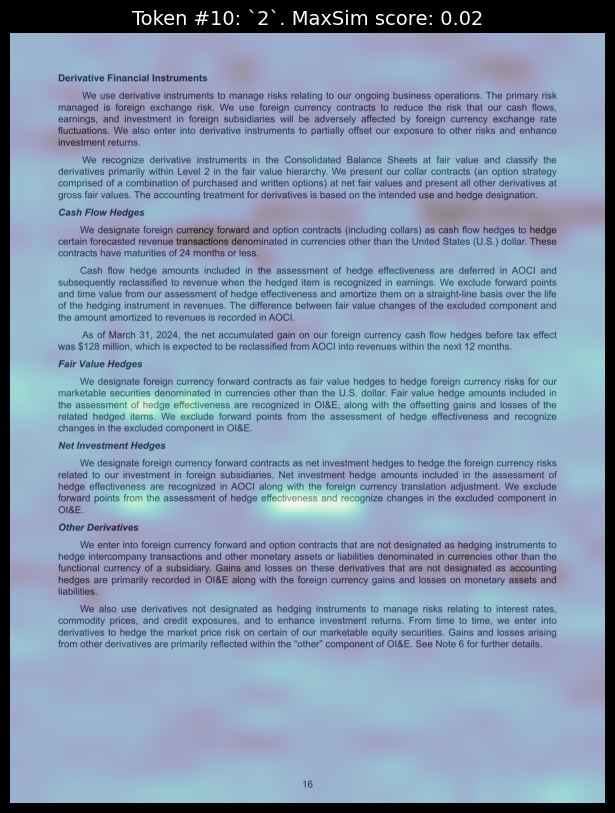

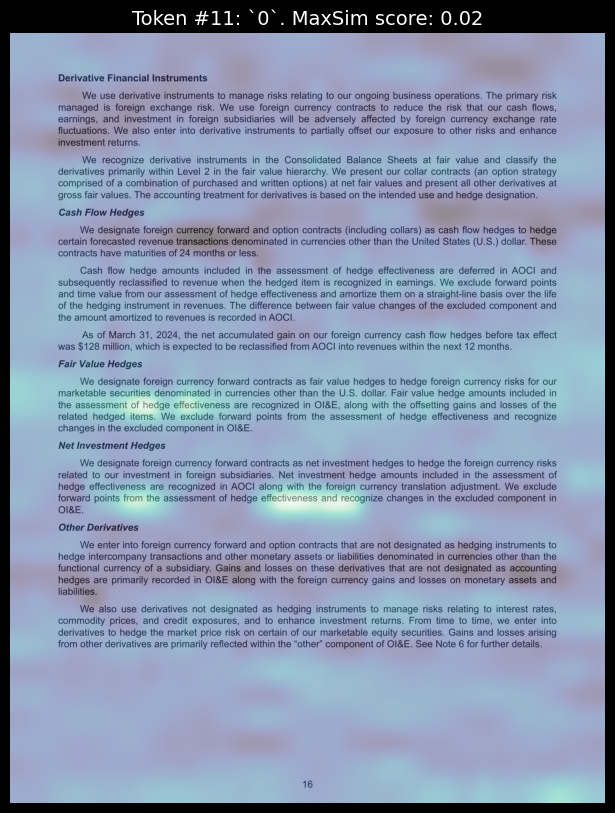

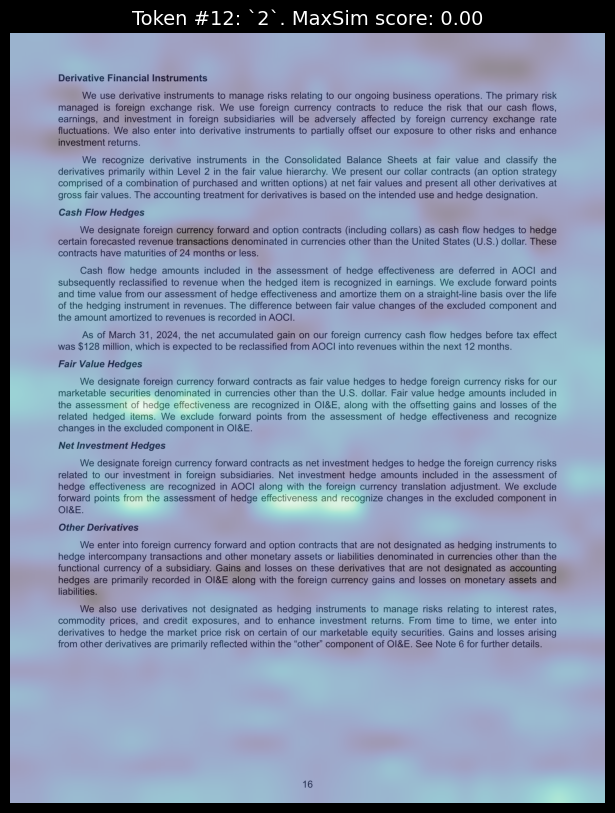

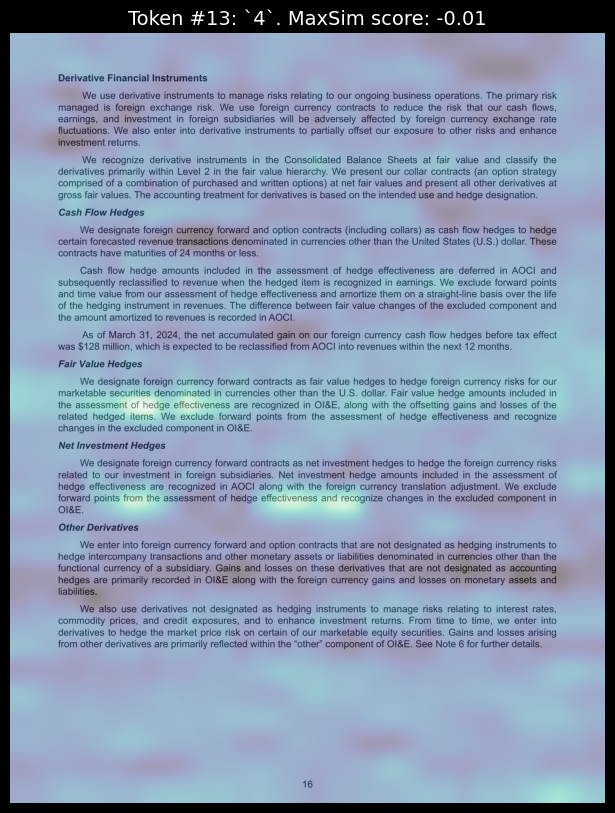

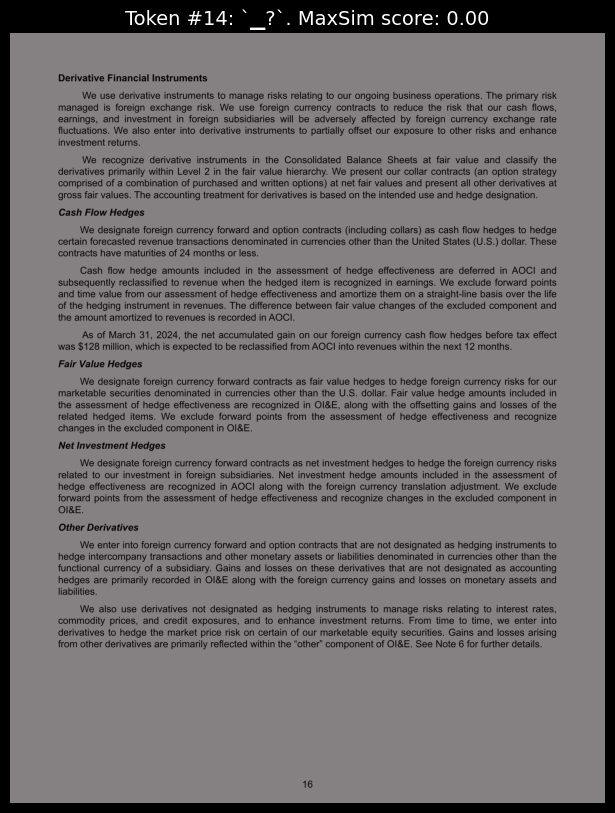

In [52]:
# Plot and save the similarity maps for each query token
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
)
#for idx, (fig, ax) in enumerate(plots):
#    fig.savefig(f"similarity_map_{idx}.png")